<a href="https://colab.research.google.com/github/Madhuri-nallamothu/AUGMENTATION_GAN/blob/master/knee-segmentation%20using-hybrid%20gan%20and%20VT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Set Up Your Colab Environment

In [1]:
# For PyTorch + Vision Transformer
!pip install timm

# For GANs and data augmentation
!pip install albumentations


In [2]:
!pip install einops

Load & Prepare Your Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os

# List contents of root drive
path = '/content/drive/MyDrive/MedicalExpert-II'
for item in os.listdir(path):
    print(item)


2Mild
1Doubtful
3Moderate
0Normal
4Severe


In [5]:
from PIL import Image
import os

# Path to your dataset
base_path = '/content/drive/MyDrive/MedicalExpert-II/'

# Pick a class folder (e.g., '0Normal')
sample_class = '0Normal'
sample_dir = os.path.join(base_path, sample_class)

# List files in the folder
image_files = [f for f in os.listdir(sample_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Load the first image and check size
if image_files:
    img_path = os.path.join(sample_dir, image_files[0])
    img = Image.open(img_path)
    print(f"Sample image path: {img_path}")
    print(f"Image size: {img.size} (Width x Height)")
else:
    print("No images found in this folder.")


Sample image path: /content/drive/MyDrive/MedicalExpert-II/0Normal/NormalG0 (8).png
Image size: (300, 162) (Width x Height)


In [6]:
# Fix for sympy compatibility issue
!pip uninstall -y sympy
!pip  install sympy==1.13.1

import os
import torch
import torchvision.transforms as transforms



Found existing installation: sympy 1.13.1
Uninstalling sympy-1.13.1:
  Successfully uninstalled sympy-1.13.1
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)


In [ ]:
# In Colab, do this in a new cell
import os
os.kill(os.getpid(), 9)


 ✅ Hybrid GAN + Vision Transformer (ViT) for Knee MRI (Reconstruction + Classification)
📁 Dataset structure: /content/drive/MyDrive/MedicalExpert-II/0Normal, ..., 4Severe


In [ ]:
# 2. Install dependencies
!pip install timm einops --quiet

In [2]:

# 3. Import libraries
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import timm


In [4]:

# 4. Define Dataset Class
class KneeMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        for label, class_name in enumerate(sorted(os.listdir(root_dir))):
            class_dir = os.path.join(root_dir, class_name)
            for file in os.listdir(class_dir):
                if file.lower().endswith(('png', 'jpg', 'jpeg')):
                    self.image_paths.append(os.path.join(class_dir, file))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# 5. Transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# 6. Dataset and DataLoader
root_path = '/content/drive/MyDrive/MedicalExpert-II'
dataset = KneeMRIDataset(root_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# 7. Define Vision Transformer Encoder
class ViTEncoder(nn.Module):
    def __init__(self):
        super(ViTEncoder, self).__init__()
        self.model = timm.create_model('vit_base_patch16_224', pretrained=True)
        self.model.head = nn.Identity()  # remove classification head

    def forward(self, x):
        x = nn.functional.interpolate(x, size=(224, 224))  # ViT input size
        return self.model(x)

# 8. Define U-Net-style Decoder
class UNetDecoder(nn.Module):
    def __init__(self, in_features=768):
        super(UNetDecoder, self).__init__()
        self.fc = nn.Linear(in_features, 512 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 256, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, 512, 8, 8)
        return self.decoder(x)

# 9. Discriminator (PatchGAN)
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, 4, 2, 1), nn.BatchNorm2d(256), nn.LeakyReLU(0.2),
            nn.Conv2d(256, 1, 4, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 10. Generator (ViT encoder + Decoder)
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ViTEncoder()
        self.decoder = UNetDecoder()
        self.classifier = nn.Linear(768, 5)  # 5 severity classes

    def forward(self, x):
        features = self.encoder(x)
        reconstructed = self.decoder(features)
        logits = self.classifier(features)
        return reconstructed, logits

# 11. Instantiate models
G = Generator().cuda()
D = Discriminator().cuda()

# 12. Losses and Optimizers
adv_loss_fn = nn.BCELoss()
recon_loss_fn = nn.MSELoss()
cls_loss_fn = nn.CrossEntropyLoss()
opt_G = torch.optim.Adam(G.parameters(), lr=2e-4)
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4)





/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [6]:
import torch.nn.functional as F  # Make sure this is somewhere at the top

epochs = 5  # increase later

for epoch in range(epochs):
    for real_imgs, labels in dataloader:
        real_imgs = real_imgs.cuda()
        labels = labels.cuda()

        # ---- Train Discriminator ----
        fake_imgs, _ = G(real_imgs)
        D_real = D(real_imgs)
        D_fake = D(fake_imgs.detach())
        d_loss = adv_loss_fn(D_real, torch.ones_like(D_real)) + \
                 adv_loss_fn(D_fake, torch.zeros_like(D_fake))

        opt_D.zero_grad()
        d_loss.backward()
        opt_D.step()

        # ---- Train Generator ----
        fake_imgs, logits = G(real_imgs)
        D_fake = D(fake_imgs)
        adv_loss = adv_loss_fn(D_fake, torch.ones_like(D_fake))

        # Resize real_imgs to match fake_imgs size
        real_imgs_resized = F.interpolate(real_imgs, size=fake_imgs.shape[2:], mode='bilinear', align_corners=False)

        # Compute losses
        recon_loss = recon_loss_fn(fake_imgs, real_imgs_resized)
        cls_loss = cls_loss_fn(logits, labels)
        g_loss = adv_loss + recon_loss + cls_loss

        opt_G.zero_grad()
        g_loss.backward()
        opt_G.step()

    print(f"Epoch {epoch+1}, D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")


Epoch 1, D Loss: 0.0281, G Loss: 6.9806
Epoch 2, D Loss: 0.0048, G Loss: 8.3478
Epoch 3, D Loss: 0.0062, G Loss: 8.4284
Epoch 4, D Loss: 0.0511, G Loss: 5.8448
Epoch 5, D Loss: 0.0193, G Loss: 6.6281


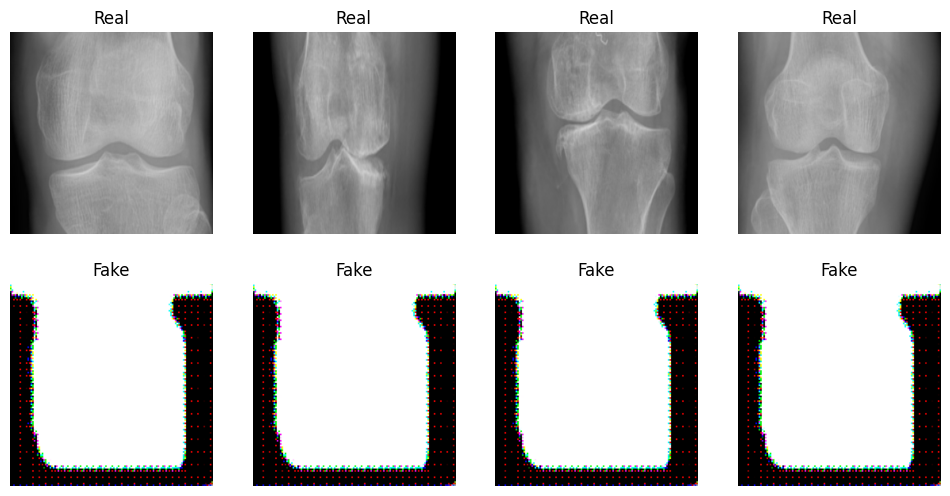

In [7]:
import matplotlib.pyplot as plt

def show_sample():
    real_imgs, _ = next(iter(dataloader))
    real_imgs = real_imgs.cuda()
    fake_imgs, _ = G(real_imgs)
    fake_imgs = fake_imgs.cpu().detach()

    fig, axes = plt.subplots(2, 4, figsize=(12, 6))
    for i in range(4):
        axes[0, i].imshow(real_imgs[i].permute(1, 2, 0).cpu())
        axes[0, i].set_title("Real")
        axes[0, i].axis("off")
        axes[1, i].imshow(fake_imgs[i].permute(1, 2, 0))
        axes[1, i].set_title("Fake")
        axes[1, i].axis("off")
    plt.show()

show_sample()
